## Setting up: 

In [414]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
# importing the module
import json

%load_ext autoreload
%autoreload 2

#additional functions:
from add_functions.proj1_helpers import *
from add_functions.ml_methods_labs import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

Note: 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [415]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [416]:
print(f'training data shape: y {y.shape}, X {tX[:1]}')

training data shape: y (250000,), X [[ 1.38470e+02  5.16550e+01  9.78270e+01  2.79800e+01  9.10000e-01
   1.24711e+02  2.66600e+00  3.06400e+00  4.19280e+01  1.97760e+02
   1.58200e+00  1.39600e+00  2.00000e-01  3.26380e+01  1.01700e+00
   3.81000e-01  5.16260e+01  2.27300e+00 -2.41400e+00  1.68240e+01
  -2.77000e-01  2.58733e+02  2.00000e+00  6.74350e+01  2.15000e+00
   4.44000e-01  4.60620e+01  1.24000e+00 -2.47500e+00  1.13497e+02]]


In [417]:
### Invalid data cleaning

### First, we should remove all the -999 values and replace it by something usefull. 
### We have two choices. Either we remove the entire sample that contains -999
### Or we replace this value with the mean of all the other values for the given feature

def replace_invalid_values_with_mean(tX, invalid_identifier):
    """Replaces invalid values with the mean of all the values in the cooresponding feature """
    nb_features = tX.shape[1]
    
    for i in range(nb_features):
        input_data = tX[:,i] # list of the given feature for all the samples
        input_data_copy = input_data.copy()
        np.delete(input_data_copy, np.where(input_data_copy == invalid_identifier)) # deleting all occurences of invalid_identifier
        valid_data_mean_1 = np.mean(input_data_copy) # mean of input data without invalid values
        tX[tX[:,i]==invalid_identifier,i] = valid_data_mean_1 # replacing all the invalid data with the above mean

    return tX

invalid_identifier = -999
tX = replace_invalid_values_with_mean(tX, invalid_identifier)


In [418]:
### Outlayers removing

def replace_outlayers_values_with_mean(tX, delta):
    """Replaces outlayers values with the mean of all the values in the cooresponding feature """
    mean = tX.mean(axis=0).reshape(1, -1)
    std_deviation = tX.std(axis=0).reshape(1, -1)
    
    threshold = delta*std_deviation
    result = np.where(np.abs(tX - mean) < threshold*np.ones_like(tX), tX, mean)
    return result

delta = 3 # we consider a value as outlay when x > delta*std_deviationtX = replace_outlayers_values_with_mean(tX, delta)
tX = replace_outlayers_values_with_mean(tX, delta)

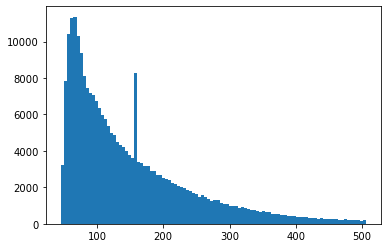

In [419]:
plt.hist(tX[:,9], bins=100)
plt.show()

In [370]:
### Encoding of y: 
y_enc = (y+1)/2
y = y_enc

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Cross validation:
Create cross validation method in order to evaluate the loss better. 

In [371]:
def build_k_indices(y, k_fold, seed=1):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [372]:
def cross_validation_sets(tX, y, k_indices,i):
    """
    cross_validation_sets: separates tX and y randomly into training and validation sets. 
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - int K: number of folds during k-fold cross-val
    @output: 
    - np.array(percentage*N,m) tX_train: training features
    - np.array(percentage*N,) y_train: training labels
    - np.array((1-percentage)*N,m) tX_val: validation features
    - np.array((1-percentage)**N,) y_val: validation labels
    """
    
    train_indices = np.concatenate(np.delete(k_indices, i, axis = 0), axis = 0)
    val_indices = k_indices[i]
    
    #creates training and validation:
    tX_train = np.take(tX, train_indices, axis = 0)
    y_train = np.take(y, train_indices, axis = 0)
    tX_val = np.take(tX, val_indices, axis = 0)
    y_val = np.take(y, val_indices, axis = 0)
    
    size = len(train_indices) + len(val_indices)
    
    assert (tX_train.shape[0] + tX_val.shape[0] == size)
    assert (y_train.shape[0] + y_val.shape[0] == size)

    return tX_train, y_train, tX_val, y_val

Different models that will be trainable:

In [373]:
models = {
    'LS_GD': 'Least squares with GD',
    'LS_SGD': 'Least squares with SGD',
    'LS_normal': 'Least squares with normal equations',
    'RR_normal': 'Ridge regression with normal equations',
    'LR': 'Logistic regression with GD'
}

Default json parameters for training, for special parameters take other file or create your own dictionary: 

In [374]:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)

### (Dimension reduction:)

In [375]:
import numpy as np
from sklearn.decomposition import PCA

tX_std = standardize(tX)

pca = PCA(n_components=4)
pca.fit(tX_std)
print(pca.explained_variance_ratio_)
#tX_pc = pd.DataFrame(pca.fit_transform(tX_std))

[0.19268422 0.09168766 0.07960786 0.0658644 ]


In [376]:
tX_pc = pd.DataFrame(pca.fit_transform(tX_std))
#tX_pc['label'] = y
#tX_pc['index'] = tX_pc.index

In [377]:
tX_pc['label'] = y
tX_pc['index'] = tX_pc.index

In [378]:
tX_pc_sample = tX_pc.iloc[np.random.choice(len(tX_std),200)]

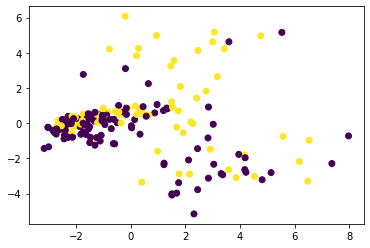

In [379]:
plt.scatter(tX_pc_sample[0],tX_pc_sample[1], c=tX_pc_sample['label'])

In [380]:
import seaborn as sns

#sns.pairplot(tX_pc_sample, hue = 'label')


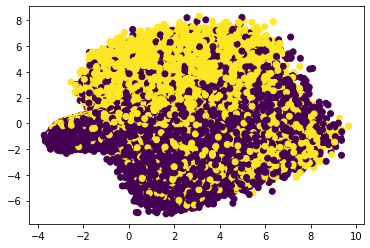

In [381]:
plt.scatter(tX_pc[0],tX_pc[1], c=tX_pc['label'])

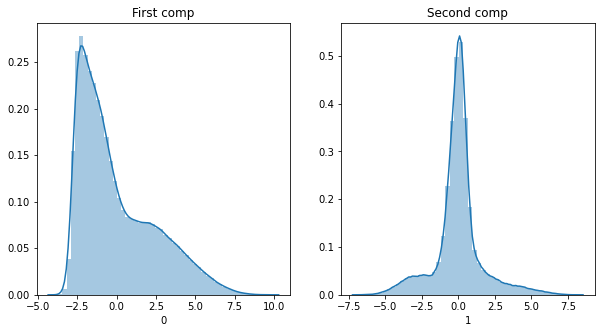

In [382]:
fig, axs = plt.subplots(1,2, figsize = (10, 5))
sns.distplot(tX_pc[0], hist=True, kde=True, ax = axs[0])
axs[0].set_title('First comp')
sns.distplot(tX_pc[1], hist=True, kde=True, ax = axs[1])
axs[1].set_title('Second comp')
fig.show()

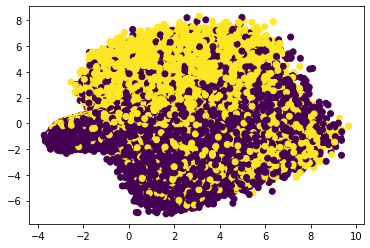

In [383]:
## Filter outliers: 
tX_pc = tX_pc[tX_pc[0]<10]
tX_pc = tX_pc[tX_pc[1]<10]
plt.scatter(tX_pc[0],tX_pc[1], c=tX_pc['label'])

In [384]:
# indices of points to keep:
indices = tX_pc.index
tX_std_filtered = pd.DataFrame(tX_std).iloc[indices].values
y_filtered = pd.DataFrame(y).iloc[indices].values.T[0]
print('Remove {x} outliers'.format(
    x=len(set(range(len(tX_std))).difference(set(indices)))))
print('New shape of tX_std: {s} and y: ({y},)'.format(s=tX_std_filtered.shape,
                                                    y=len(y_filtered)))

Remove 0 outliers
New shape of tX_std: (250000, 30) and y: (250000,)


In [385]:
tX_std = tX_std_filtered
y = y_filtered

In [386]:
'''
k_indices = build_k_indices(tX, K)
tX_train, y_train, tX_val, y_val = cross_validation_sets(tX, y, k_indices, i)
'''

'\nk_indices = build_k_indices(tX, K)\ntX_train, y_train, tX_val, y_val = cross_validation_sets(tX, y, k_indices, i)\n'

### Feature expansion:
Polynomial feature expansion: $X' = [1, X, X^2]$

In [387]:
def poly_feats(tX, degree):  
    if not np.array_equal(tX[:, 0], np.ones(len(tX))):
            # add bias term:
            tX_poly = np.hstack((np.ones((len(tX), 1)), tX))
    for deg in range(degree, degree+1):
        tX_poly = np.c_[tX_poly, np.power(tX, deg)]
    return tX_poly
"""
Test:
assert (np.array_equal(
    pd.DataFrame(build_poly(tX, 2)).values[:, 1:31],
    pd.DataFrame(tX).values[:, 0:30]))"""

'\nTest:\nassert (np.array_equal(\n    pd.DataFrame(build_poly(tX, 2)).values[:, 1:31],\n    pd.DataFrame(tX).values[:, 0:30]))'

### Training: 
Global training function where each model can be called.

In [388]:
def train_model(tX,
                y,
                model='LS_GD',
                initial_w=None,
                param=default_parameters,
                verbose=True
                ):
    """
    train_model: trains a model according to their parameters in the dictionnary
    @input:
        - np.array(N,) y: labels
        - np.array(N,m) tX: features
        - string model: 'LS_GD', 'LS_SGD', 'LS_normal', 'RR_normal' or 'LR'
        - np.array(m,) initial_w: starting weights for GD and SGD
        - dictionary param: different parameters required for training (lr, lambda, etc)
    @output: 
        - np.array(m,) best_w: weights that got the smallest loss during cross-val
        - double avg_loss: average loss over validation sets during cross-val
    """
    # will keep last weights and last loss
    weights, loss = [], []
    parameters = param[model]

    # parameters:
    K, MAX_ITERS, POLY = parameters['K'], parameters['max_iters'], parameters[
        'poly']

    # will keep all losses during training
    costs_ = np.zeros([K, MAX_ITERS])
    train_costs_ = np.zeros([K, MAX_ITERS])
    
    if verbose:
        print(
            f'{models[model]} starting with: \nInitial_w: {initial_w},\nParameters:{parameters}'
        )
        print('------------------')
        print('START TRAINING:')

    # get indices of k-fold:
    k_indices = build_k_indices(y, K)

    # polynonmial expansion:
    tX_pol = poly_feats(tX, POLY)

    # standardize:
    tX_std = standardize(tX_pol)
    
    if verbose:
        print(f'Data shape:{tX_std.shape}')

    # initial_w:
    if initial_w == None:
        initial_w = np.zeros(tX_std.shape[1])

    for i in range(K):
        if verbose:
            print(f'K = {i+1}')
        # create training and validation sets:
        tX_train, y_train, tX_val, y_val = cross_validation_sets(
            tX_std, y, k_indices, i)

        #start with initial_w:
        w = initial_w.copy()
        # keep tabs on losses during training
        cost_history = []
        train_cost_history = []

        # if RR_normal or LS_normal no GD:
        if model == 'RR_normal':
            w, cost_history = ridge_regression_update(tX_train, y_train,
                                                      tX_val, y_val,
                                                      parameters)
            cost = cost_history
            if verbose:
                print(f'Final loss:{cost}')
        elif model == 'LS_normal':
            w, cost_history = least_squares_update(tX_train, y_train, tX_val,
                                                   y_val)
            cost = cost_history
            if verbose:
                print(f'Final loss:{cost}')
        
        # else GD:
        else:
            for j in range(MAX_ITERS):
                if model == 'LR':
                    # calculate loss:
                    cost = cost_logistic(tX_val, y_val, w, parameters)
                    cost_history.append(cost)
                    train_cost_history.append(
                        cost_logistic(tX_train, y_train, w, parameters))
                    # Update weights:
                    w = update_weights_logistic(tX_train, y_train, w,
                                                parameters)
                if model == 'LS_GD':
                    # calulate loss:
                    cost = MSE_loss(y_val, tX_val, w)
                    cost_history.append(cost)
                    train_cost_history.append(MSE_loss(y_train, tX_train, w))
                    # Update weights:
                    w = update_weights_LS_GD(tX_train, y_train, w, parameters)
                if model == 'LS_SGD':
                    # calulate loss:
                    cost = MSE_loss(y_val, tX_val, w)
                    cost_history.append(cost)
                    train_cost_history.append(MSE_loss(y_train, tX_train, w))
                    # update weights:
                    w = update_weights_LS_SGD(tX_train, y_train, w, parameters)
            
            if verbose:
                print(f'Final loss:{cost}')
        # Add last weights and loss for auditing:
        weights.append(w)
        loss.append(cost)
        costs_[i] = cost_history
        if model != 'LS_normal' and model != 'RR_normal':
            train_costs_[i] = train_cost_history
        if verbose:
            print('------------------')
    
    if verbose:
        print('Average loss: {avg_loss}'.format(avg_loss=np.mean(loss)))

    # best weights of min loss:
    best_w = weights[np.argmin(loss)]

    # Plot loss evolution for GD:
    if model != 'LS_normal' and model != 'RR_normal' and verbose:
        print('------------------')
        print('Loss evolution:')
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(costs_.T)
        ax[0].set_title(models[model] + ' , validation loss')
        ax[0].legend(range(1, K + 1))

        ax[1].plot(train_costs_.T)
        ax[1].set_title(models[model] + ' , training loss')
        ax[1].legend(range(1, K + 1))

    return best_w, np.mean(loss)

### Least Squares GD: 
Linear regression using gradient descent. 

In [389]:
def gradient_MSE(y, tx, w):
    """
    gradient_MSE: calculates the gradient of the MSE function 
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    @output: np.array(m,) gradient of MSE
    """
    return (-1 / len(y)) * tx.T @ (y - tx @ w)

In [390]:
def MSE_loss(y, tx, w):
    """
    MSE_loss: calculates the MSE loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    @output: double, MSE loss
    """
    assert(w.shape[0] == tx.shape[1])
    assert(y.shape[0] == tx.shape[0])
    MSE = np.square(np.subtract(y,tx @ w)).mean()
    return MSE

# Test MSE loss function with random weight vector:
"""from sklearn.metrics import mean_squared_error
w = np.random.rand(tX.shape[1]+1)
assert (mean_squared_error(y, tX_std @ w) == MSE_loss(y, tX_std, w))"""

'from sklearn.metrics import mean_squared_error\nw = np.random.rand(tX.shape[1]+1)\nassert (mean_squared_error(y, tX_std @ w) == MSE_loss(y, tX_std, w))'

In [391]:
def update_weights_LS_GD(tX, y, w, parameters):
    """
    update_weights_LS_GD: one step of GD with MSE
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: updated weights according to GD
    """    
    # get parameters:
    lr = parameters['lr']
    # calculate gradient:
    grad = gradient_MSE(y, tX, w)
    # update weights:
    w -= lr * grad
    return w

In [392]:
def least_squares_GD(tx, y, initial_w, parameters):
    """
    least_squares_GD: training with least squares GD
    @input:
    - np.array(N,m) tx: features
    - np.array(N,) y: labels
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """
    model = 'LS_GD'
    best_w, avg_loss = train_model(tX=tx,
                                   y=y,
                                   model=model,
                                   initial_w=initial_w,
                                   param=parameters)

    return best_w, avg_loss

Least squares with GD starting with: 
Initial_w: None,
Parameters:{'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.18320616247950514
------------------
K = 2
Final loss:0.18476156636094035
------------------
K = 3
Final loss:0.18308451682965016
------------------
K = 4
Final loss:0.18446918780725277
------------------
K = 5
Final loss:0.18506760203811448
------------------
Average loss: 0.18411780710309258
------------------
Loss evolution:


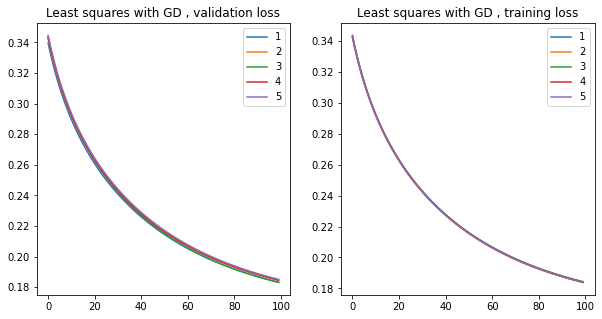

In [393]:
# polynomial feature expansion:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)

best_w, avg_loss = least_squares_GD(tx=tX,
                                    y=y,
                                    initial_w=None,
                                    parameters=default_parameters)

### Least Squares SGD:
Linear regression using stochastic gradient descent

In [394]:
def update_weights_LS_SGD(tX, y, w, parameters):
    """
    update_weights_LS_SGD: one step of SGD with MSE
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: updated weights according to SGD
    """   
    # get parameters:
    lr = parameters['lr']
    # batch_size to 1 for SGD, otherwise mini-batch:
    batch_size = parameters['batch_size']

    for minibatch_y, minibatch_tx in batch_iter(y, tX, batch_size):
        # calculate gradient on batch:
        grad = gradient_MSE(minibatch_y, minibatch_tx, w)
        # update weights:
        w -= lr * grad
    return w

In [395]:
def least_squares_SGD(tx, y,initial_w, parameters):
    """
    least_squares_SGD: training with least squares SGD
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LS_SGD'
    best_w, avg_loss = train_model(tX = tx, y= y, 
                                   model=model, initial_w=initial_w, 
                                   param= parameters)
    return best_w, avg_loss

Least squares with SGD starting with: 
Initial_w: None,
Parameters:{'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2, 'batch_size': 1}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.2274310889633057
------------------
K = 2
Final loss:0.2609356541655079
------------------
K = 3
Final loss:0.29618568003450296
------------------
K = 4
Final loss:0.2948796411710879
------------------
K = 5
Final loss:0.2801963620777855
------------------
Average loss: 0.271925685282438
------------------
Loss evolution:


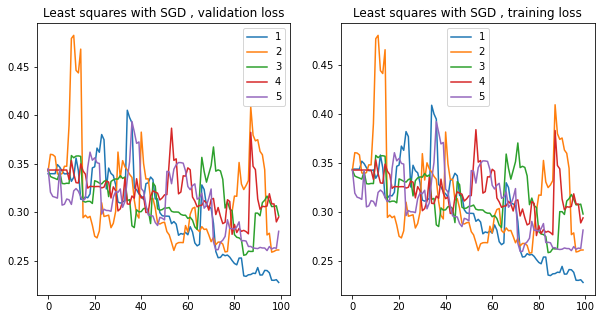

In [396]:
# Test of LS-SGD:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = least_squares_SGD(tx=tX,
                                    y=y,
                                    initial_w=None,
                                    parameters=default_parameters)

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [397]:
def least_squares_update(tX_train, y_train, tX_val, y_val):
    """
    least_squares_update: weights with normal equations of least squares
    @input:
    - np.array(N,) y_train and y_val: training and validation labels
    - np.array(N,m) tX_train and tX_val: training and validation features
    @output: 
    - np.array(m,) w: weights 
    - double loss: MSE loss
    """        
    # "train": 
    w = np.linalg.solve(tX_train.T @ tX_train, tX_train.T @ y_train)
    # evaluate loss on validation set:
    loss = MSE_loss(y_val, tX_val, w)
    return w, loss

Pas nécessaire de garder cette fonction `least_squares` si c'est ok d'avoir juste une fx train, un peu inutile... 


In [398]:
def least_squares(y, tx, parameters):
    """
    least_squares: weights with normal equations of least squares
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    @output:
    - np.array(m,) best_w: weights with smallest loss during cross-val 
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LS_normal'
    best_w, avg_loss = train_model(tX = tx, y= y, 
                                   model=model,
                                   param=parameters)
    return best_w, avg_loss

In [399]:
# Test of LS_normal:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = least_squares(y = y, tx = tX, parameters = default_parameters)

Least squares with normal equations starting with: 
Initial_w: None,
Parameters:{'max_iters': 1, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.15082947151984444
------------------
K = 2
Final loss:0.15186979714111193
------------------
K = 3
Final loss:0.15072371769304346
------------------
K = 4
Final loss:0.15130862339033116
------------------
K = 5
Final loss:0.15192128909604646
------------------
Average loss: 0.15133057976807546


### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [400]:
def ridge_regression_update(tX_train, y_train, tX_val, y_val, parameters):
    """
    least_squares_update: weights with normal equations of least squares
    @input:
    - np.array(N,) y_train and y_val: training and validation labels
    - np.array(N,m) tX_train and tX_val: training and validation features
    - dict parameters: dictionnary of required parameters
    @output:
    - np.array(m,) w: weights 
    - double loss: MSE loss
    """
    # get parameters:
    lambda_ = parameters['lambda_']

    # "train":
    w = np.linalg.solve(
        tX_train.T @ tX_train + lambda_ * np.eye(tX_train.shape[1]),
        tX_train.T @ y_train)

    # evaluate loss on validation set:
    loss = MSE_loss(y_val, tX_val, w)
    return w, loss

A nouveau, pas nécessaire de garder cette fonction `ridge_regression` si c'est ok d'avoir juste une fx train, un peu inutile...

In [401]:
def ridge_regression(y, tx, parameters):
    """
    ridge_regression: weights with normal equations of ridge regression
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    @output:
    - np.array(m,) best_w: weights with smallest loss during cross-val 
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'RR_normal'
    best_w, avg_loss = train_model(tX = tx, y= y, 
                                   model=model,
                                   param=parameters)
    return best_w, avg_loss

In [402]:
# Test of RR_normal:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = ridge_regression(y = y, tx = tX, parameters = default_parameters)

Ridge regression with normal equations starting with: 
Initial_w: None,
Parameters:{'max_iters': 1, 'K': 5, 'lambda_': 0.02, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.1508294712205794
------------------
K = 2
Final loss:0.15186979647625753
------------------
K = 3
Final loss:0.15072371995999959
------------------
K = 4
Final loss:0.15130862326382905
------------------
K = 5
Final loss:0.15192128626136853
------------------
Average loss: 0.15133057943640682


### Logistic (regularized) regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

- cost : $J(w) = -1/m (-y^T log (h)-(1-y)^T log (1-h)) + \lambda/(2m)||w||^2 ; h = sigmoid(Xw)$

Regularized logistic regression using gradient descent or SGD. $ w^* = min_w \sum_{i=1}^n log(1+exp(-y_i w^T x_i)) +\lambda ‖w‖^2$

In [403]:
def sigmoid_activation(z):
    """
    sigmoid_activation: calculates the sigmoid activation of a vector z
    @output: np.array(m,) 
    """
    return 1.0 / (1.0 + np.exp(-z))

In [404]:
def cost_logistic(tX, y, w, parameters):
    """
    cost_logistic: calculates the logistic (regularized) loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - double cost: logistic loss
    """     
    # get parameters:
    lambda_ = parameters['lambda_']
    
    predictions = sigmoid_activation(tX @ w)
    m = y.shape[0]
    
    #Take the sum of both costs: error when label=1 + error when label=0
    cost = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    
    #Take the average cost:
    cost = cost.sum() / m

    # regularizer:
    if lambda_:
        cost += (lambda_ / (2 * m)) * w.T @ w
    return cost

In [405]:
def update_weights_logistic(tX, y, w, parameters):
    """
    update_weights_logistic: one iteration with GD on logistic (regularized) loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights to be updated
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) w: new weights
    """     
    
    # get parameters:
    lr = parameters['lr']
    lambda_ = parameters['lambda_']
    m = len(tX)
    
    #Get Predictions:
    predictions = sigmoid_activation(np.dot(tX, w))

    # slope of the cost function across all observations
    gradient = (tX.T @ (predictions - y))

    # if regularization
    if lambda_:
        gradient += lambda_ * w
    
    gradient /= m
    
    # Subtract from our weights to minimize cost
    w -= lr * gradient
    return w

In [406]:
def logistic_regression(y, tx, initial_w, parameters):
    """
    logistic_regression: logistic (regularized) regression with GD
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LR'
    best_w, avg_loss = train_model(tX = tx, y= y, 
                                   model=model, initial_w=initial_w, 
                                   param= parameters)
    return best_w, avg_loss

Logistic regression with GD starting with: 
Initial_w: None,
Parameters:{'lambda_': 0.02, 'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.5831596051369992
------------------
K = 2
Final loss:0.5832046232954741
------------------
K = 3
Final loss:0.5813605965063683
------------------
K = 4
Final loss:0.5822759879331024
------------------
K = 5
Final loss:0.5827478988894226
------------------
Average loss: 0.5825497423522734
------------------
Loss evolution:


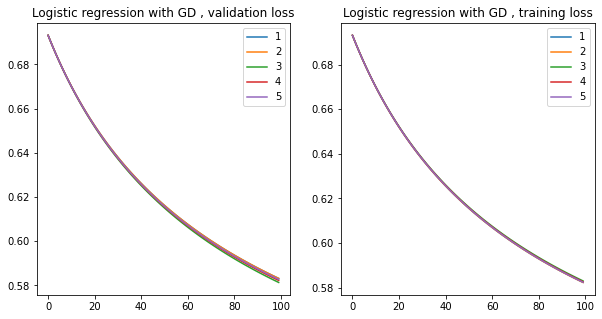

In [407]:
# Test of logistic regularized regression:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = logistic_regression(tx=tX,
                                    y=y,initial_w=None,
                                    parameters=default_parameters)

## Hyperparameters Tuning

### Randomized Grid search
[Cross-Validation and Hyperparameter Tuning: How to Optimise your Machine Learning Model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d)

In [408]:
from tqdm import tqdm

def randomized_grid_search(model, tX, y, initial_w, parameters_lists, nb_rnd_test, verbose=False):
    '''
    randomized_grid_search: Search the best parameters with the model among
    a list of value for each parameter.
    @input:
    - string model: 'LS_GD', 'LS_SGD', 'LS_normal', 'RR_normal' or 'LR'
    - np.array(N,m) tX: features
    - np.array(N,) y: labels
    - np.array(m,) initial_w: starting weights for GD and SGD
    - dictionary parameters_lists: A dictionary of lists of values for the parameters
        required for training (lr, lambda, etc)
    - int nb_rnd_test: number of random test to do before giving the best results it found.
    @output
    - double avg_loss: average loss over validation sets during cross-val
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - dictionary new_params: The parameters we acheived the best result with
    - int nb_rnd_test: same as the input
    '''
    results = []
    for i in tqdm(range(nb_rnd_test)):
        new_params = {}
        
        # Select a random combinations of parameters
        for k,v in parameters_lists[model].items():
            new_params[k] = np.random.choice(v)
        
        param_to_test_with={model:new_params.copy()}
        
        # Train the model and store the results
        best_w, avg_loss = train_model(tX, y, model, initial_w, param_to_test_with, verbose)
        results.append((avg_loss, best_w, param_to_test_with))
        
    # Return the parameters with the smaller loss
    return sorted(results, key=lambda e: e[0])[0], nb_rnd_test

#### Tuning

##### Generate parameters posibilities (modify these as you want to)

In [409]:
# Generate parameters (adapt these as you want to) depending on the one we need for the given model
rnd_grid_search_params = {
    'LR':{
        'lambda_': [x for x in np.linspace(0.01,0.21,100)],
        'lr': [x for x in np.linspace(0.01,0.21,100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1,10,10)],
        'poly':[i for i in range(1,5)]
    },
    'LS_GD':{
        'lr': [x for x in np.linspace(0.01,0.21,100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1,10,10)],
        'poly':[i for i in range(1,5)]
    },
    'LS_SGD':{
        'lr': [x for x in np.linspace(0.01,0.21,100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1,10,10)],
        'poly':[i for i in range(1,5)],
        'batch_size':[1]
    },
    'LS_normal':{
        'max_iters': [1],
        'K': [int(i) for i in np.linspace(1,10,10)],
        'poly':[i for i in range(1,5)]
    },
    'RR_normal':{
        'max_iters': [1],
        'K': [int(i) for i in np.linspace(1,10,10)],
        'lambda_': [x for x in np.linspace(0.01,0.21,100)],
        'poly':[i for i in range(1,5)]
    }
}

In [410]:
from datetime import datetime

def search_and_save_params(model, tX, y, initial_w, parameters_lists, nb_rnd_test, verbose=False):
    result = randomized_grid_search(model,
                                    tX,
                                    y,
                                    initial_w,
                                    parameters_lists,
                                    nb_rnd_test,
                                    verbose=False)
    now = datetime.now().strftime('%m(month)-%d_%Hh%Mm%Ss')
    model = list(result[0][2].keys())[0]

    OUTPUT_PATH = '../data/results/param_tuning_' + model + '_' + str(now) + '.txt'

    data=str('avg_loss:{}\nparameters:{}\nnb_rnd_try:{}\nw:{}'.format(
        result[0][0], result[0][2], result[1], result[0][1]))

    with open(OUTPUT_PATH,'w') as output:
        output.write(str(data))
    
##################################################################
# /!\ If this fail, create a directory named 'results' in 'data' #
##################################################################

In [411]:
search_and_save_params(model='LS_normal',
                       tX=tX,
                       y=y,
                       initial_w=None,
                       parameters_lists=rnd_grid_search_params,
                       nb_rnd_test=50,
                       verbose=False)

  0%|          | 0/50 [00:01<?, ?it/s]


LinAlgError: Singular matrix

## Training with special parameters: 

For other parameters than in the default, change json or create a new dict.

In [ ]:
## Training with k-fold:
model = 'LR'

with open('parameters.json') as json_file:
    parameters = json.load(json_file)

best_w, avg_loss = train_model(tX=tX,
                               model=model,
                               y=y,
                               initial_w=None,
                               param=parameters)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

In [ ]:
# Standard par rapport à moyenne et std de train:
POLY = parameters[model]['poly']

poly_X_test =  poly_feats(tX_test, POLY)
poly_X_train = poly_feats(tX, POLY)

mean_train = np.mean(poly_X_train[:,1:], axis=0)
std_train = np.std(poly_X_train[:,1:] - mean_train, axis=0)

tX_test_std = standardize_with_mean_std(poly_X_test, mean_train, std_train)

In [ ]:
# Choose method: 
from datetime import date
today = date.today().strftime('%m-%d')

# parameters:
params = ''
for param in parameters[model]:
    params+= param+'='+str(parameters[model][param])+','

test_prediction = predict_labels(best_w, tX_test_std)
OUTPUT_PATH = '../data/results/y_pred_' + model + '_'+str(today)+'_'+params+'.csv'
ids_test = pd.read_csv('../data/sample-submission.csv')['Id']
create_csv_submission(ids_test, test_prediction, OUTPUT_PATH)

##################################################################
# /!\ If this fail, create a directory named 'results' in 'data' #
##################################################################

## Next: 

- Grid search for best parameters
- Pre-processing: look for outliers, etc
- Dimension reduction by PCA or Laplacian dimension reduction.
- Etude comparative
- implentations.py
- Rapport

### Questions: 
- encoding of y : 0vs1 / -1vs1 ? 
- predict labels ? 
Jäggi: more/better data cleaning, preprocessing and feature expansions or variants for example